---
# Méthode OLA (Overlap-Add) pour appliquer un filtre RIF via FFT
---

## Introduction 

Dans ce notebook, on va montrer comment économiser des opérations CPU pour appliquer un filtre RIF, au prix d'un délai plus élevé entre l'entrée et la sortie du filtre, et en ayant besoin de plus de mémoire RAM. Pour cela, on présentera et expliquera les méthodes Overlap-Save et Overlap-Add.

Après avoir synthétisé un filtre, on obtient une réponse impulsionnelle, et on sait qu'on peut utiliser une convolution pour l'appliquer à un signal. Or la convolution coûte très cher en calcul (on va re-détailler ça plus loin). On va voir ici que si on peut se permettre de *bufferiser* le signal, c'est-à-dire d'enregistrer un certain nombre de valeurs du CAN en mémoire avant de les traiter, alors on peut appliquer le filtre dans le domaine de Fourier.

En effet, une convolution dans le domaine temporel est équivalente à une simple multiplication terme-à-terme dans le domaine de Fourier. Si on fait une FFT (assez économe en calcul) sur le signal d'entrée et qu'on connaît la TF du filtre, on peut alors filtrer par multiplication terme-à-terme. L'objectif est de prendre comprendre la subtilités de l'application d'un filtre dans le domaine fréquentiel (au lieu du domaine temporel), et d'être capable de l'implémenter en pratique.


--- 
# Filtrage causal par convolution

Pour cette première partie, un [résumé vidéo commenté "Convolution et filtres numériques" est disponible sur Youtube](https://youtu.be/VlEqIMpqFII).

On va utiliser les notations suivantes pour les signaux : 
* $x[n] \in \mathbb{R}$ est le signal d'entrée
* $h[n] \in \mathbb{R}$ est la réponse impulsionnelle du filtre
* $y[n] = (h * x)[n]$ est le signal de sortie (filtré). $y[n]  \in \mathbb{R} $

De plus :
* On note $L$ le nombre de coefficients du filtre RIF
* On note $b_l$ les coefficients du numérateur de la fonction de transfert, avec $0 \leq l \leq L-1$. Pour un filtre RIF, on rappelle que $h[l] = b_l$
* Le filtre est causal, d'où $\forall n<0, h[n] = 0$
* Le filtre est RIF, d'où $ \forall n \geq L, h[n] = 0$
* $N$ est le nombre total d'échantillons (non-nuls) en entrée

## Construction du signal d'exemple

On va générer un signal avec 3 composantes sinusoïdales ($f_1 = 1kHz, f_2=4kHz, f_3=16kHz$) et du bruit gaussien :

$$
x(t) = \cos(2 \pi f_1 t) + \cos(2 \pi f_2 t) + \cos(2 \pi f_3 t) + b(t) \\
\text{avec } b(t) \sim \mathcal{N} \left( 0, \sigma ^2 \right)
$$

Et on échantillonne ce signal à la fréquence $F_s = 50kHz$, en prenant $x[n] = x(t = n / F_s)$

On souhaitera ensuite récupérer uniquement la composante centrale $f_2$, en filtrant les composantes latérales et le bruit par un passe-bande.

Text(0, 0.5, '|X(f)|')

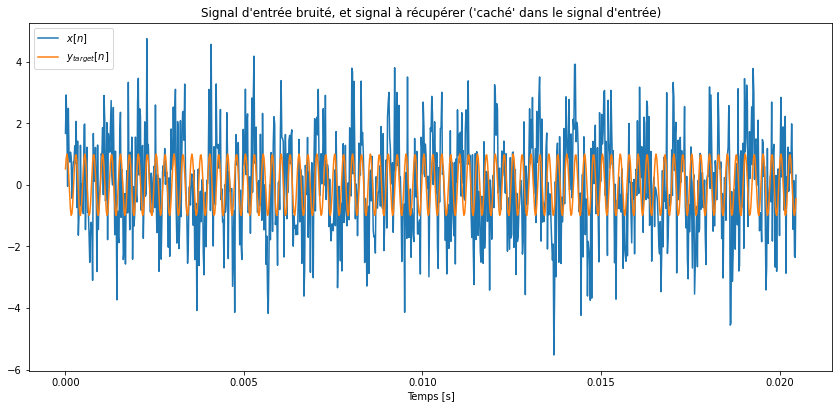

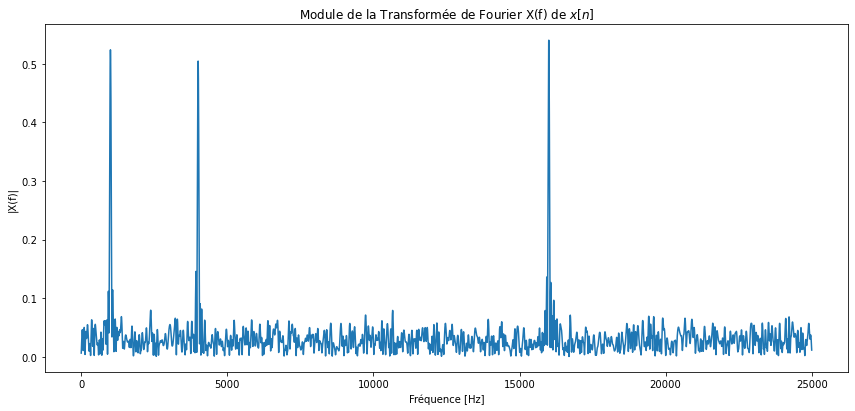

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Affichage interactif - installer extensions nécessaires
#%matplotlib widget
# Garder inline pour export HTML (qui intégrera aussi les vidéos) et pour visu directe sur Github
%matplotlib inline
import scipy.signal as signal
import random
random.seed(2021)
np.random.seed(2021)  # commenter pour "lâcher" le générateur gaussien

figs_scale = 1.6  # 1.6 si matplotlib inline (dpi fixés dans Jupyter), 1.0 si widgets interactifs

Fs = 50e3  # échantillonnage à 50kHz
N = 1024
t = np.linspace(0.0, (N-1)/Fs, N, endpoint=True)

# Génération des signaux
f1, f2, f3 = 1e3, 4e3, 16e3  # Fréquences des raies spectrales, en Hz
nu1, nu2, nu3 = f1/Fs, f2/Fs, f3/Fs  # équivalents en fréq normalisée dans [-0.5, 0.5[
y_target = 1.0 * np.cos(2*np.pi*(f2 * t + random.random()))  # raie centrale, à récupérer
x = 1.0 * np.cos(2*np.pi*(f1 * t + random.random())) + y_target + 1.0 * np.cos(2*np.pi*(f3 * t + random.random()))
x += np.random.normal(0.0, 1.0, N)  # Bruit gaussien centré, fort écart type vs. amplitude raies spectrales
# Affichage des signaux - représentation temporelle
fig, ax = plt.subplots(1, 1, figsize=(figs_scale*9, figs_scale*4))
ax.plot(t, x)
ax.plot(t, y_target)
ax.legend([r'$x[n]$', r'$y_{target}[n]$'])
ax.set_title("Signal d'entrée bruité, et signal à récupérer ('caché' dans le signal d'entrée)")
ax.set_xlabel('Temps [s]')
# FFT avec zero-padding pour voir le spectre en détail
fig, ax = plt.subplots(1, 1, figsize=(figs_scale*9, figs_scale*4))
M = 2**14  # taille FFT avec zero-padding auto dans numpy.fft
X = np.abs(np.fft.fft(x, M))[0:M//2] / N  # Amplitude normalisée, 1/2 spectre pour les fréquences positives
ax.plot(np.linspace(0.0, 0.5, M//2) * Fs, X)
ax.set_title(r'Module de la Transformée de Fourier X(f) de $x[n]$')
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel(r'|X(f)|')

## Synthèse du filtre RIF et filtrage par convolution

On va ici synthétiser un filtre RIF par méthode "de fenêtrage", sans rappeler en quoi cette méthode consiste.
Le filtre obtenu est décrit par sa réponse impusionnelle discrète $h[l]$ avec $0 \leq l \leq L-1$.

La taille $L$ de la réponse impulsionnelle est aussi le nombre de coefficients du filtre.

Text(0.5, 0, 'Fréquence [Hz]')

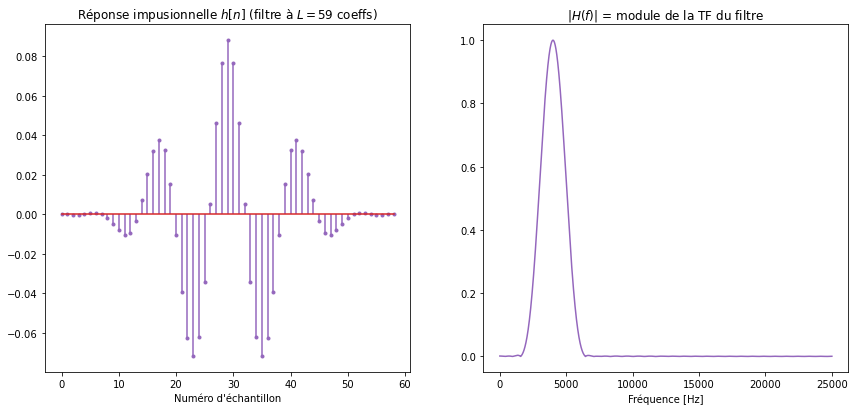

In [2]:
# Exemple de convolution avec filtre passe-bande synthétisé par méthode basique : R.I. fenêtrée
L = 59  # TAILLE DU FILTRE
h = signal.firwin(L, [0.12, 0.20], pass_zero='bandpass')  # Attention : fréq normalisée dans [-1, 1[
fig, axes = plt.subplots(1, 2, figsize=(figs_scale*9, figs_scale*4))
axes[0].stem(h, linefmt='C4-', markerfmt='C4.')
axes[0].set_title('Réponse impusionnelle $h[n]$ (filtre à $L=$' + '{} coeffs)'.format(L))
axes[0].set_xlabel("Numéro d'échantillon")
axes[1].plot(np.linspace(0.0, 0.5, M//2, endpoint=False) * Fs, np.abs(np.fft.fft(h, M))[0:M//2], 'C4-')
axes[1].set_title('$|H(f)|$ = module de la TF du filtre')
axes[1].set_xlabel('Fréquence [Hz]')

On peut maintenant appliquer notre filtre $h[n]$ à notre signal d'entrée $x[n]$. Pour cela, la méthode de base est la convolution discrète des signaux $x[n]$ et $h[n]$. On peut considérer que le filtre, via sa réponse impulsionnelle $h[n]$, est lui-même un signal !

Pour obtenir la sortie $y[n]$, on utilise la convolution qui est définie par :

$$
y[n] = (h*x)[n] = \sum_{k=-\infty}^{+\infty} h[k] x[n-k]
$$

Mais avec un filtre RIF, on sait que $h[k] = 0$ si $k<0$ ou bien si $k>L-1$. On peut donc (heureusement) simplifier cette somme infinie, et on obtient :

$$
y[n] = (h*x)[n] = \sum_{k=0}^{L-1} h[k] x[n-k]
$$

On voit que :
* pour calculer la sortie $y[n]$ à un instant donné $n \in \mathbb{Z}$, il faut connaître les $L$ derniers échantillons de l'entrée $x$, c'est à dire : $x[n], x[n-1], ..., x[n-(L-1)]$
* Dans la somme, on ne parcourt pas les signaux $h$ et $x$ dans le même sens. On va en "retourner" un par rapport à l'autre, avant de les multiplier.

In [3]:
from matplotlib import animation, rc
from IPython.display import HTML

N_ = 3*L + L-1  # Convolution animée : sur le début du signal seulement
signal_amplitudes_display = [-4.1, 4.1]
# On allonge le signal d'entrée sur les n<0, pour commencer la conv à n=0
x_ = np.hstack((np.zeros(L-1), x[0:N_ - (L-1)]))
abscisses_echantillons = np.arange(-(L-1), N_ - (L-1))
y_target_ = y_target[0:N_ - L]
# On pré-calcule y (rendu HTML demande des incides aléatoires...)
y_conv = signal.convolve(x, h, mode='full', method='direct')
# Affichage animé - rendu vidéo
fig, axes = plt.subplots(4, 1, figsize=(figs_scale*9, figs_scale*7.5), sharex=True)
axes[0].set_title("Signal d'entrée $x[n]$ et signal $y_{target}[n]$ qu'on souhaite récupérer")
axes[0].stem(abscisses_echantillons, x_, markerfmt='.')
axes[0].stem(y_target_, linefmt='C1-', markerfmt='C1.')
axes[0].legend(['$x[n]$', '$y_{target}[n]$'])
axes[0].set_ylim(signal_amplitudes_display)
def animate(n):
    axes[1].clear()
    axes[1].set_title("Portion du signal $x[n]$ qui sert pour la convolution avec $h$")
    axes[1].set_ylim(signal_amplitudes_display)
    current_x = x_[n: n+L]
    axes[1].stem(np.arange(n-(L-1), n+1), current_x, markerfmt='C0.')
    axes[1].text(n+2, -0.3, "$x[n]$")
    axes[1].text(n-(L-1)-24, -0.3, "$x[n-L+1]$")
    axes[2].clear()
    axes[2].stem(np.arange(n-(L-1), n+1), h[::-1], linefmt='C4-', markerfmt='C4.')  # h symétrique, on pourrait enlever le retournement horizontal
    axes[2].set_title("Réponse impulsionnelle $h$ décalée et retournée horizontalement")
    axes[2].legend(['$h$'])
    axes[2].text(n+2, -0.005, "$h[0]$")
    axes[2].text(n-(L-1)-18, -0.005, "$h[L-1]$")
    axes[3].clear() 
    axes[3].set_title("Sortie $y_{conv}[n]$ = résultat de la convolution $(h*x)[n]$")
    axes[3].set_xlabel("Numéro d'échantillon")
    axes[3].set_ylim(signal_amplitudes_display)
    axes[3].stem(np.arange(0, n+1), y_conv[0:n+1], linefmt='C1-', markerfmt='C1.')
    axes[3].text(-50.0, -0.7, "n={}".format(n), fontsize=20)
    axes[3].text(n+2, -0.3, "$y[n]$")
    fig.tight_layout()
    return ()
# Frames pour les k>=0 (on convolue seulement pour les 'vrais' échantillons x[k])
anim = animation.FuncAnimation(fig, animate, frames=N_-L, interval=200, blit=True)  # N_-L frames
plt.close()  # on ne garde que l'anim

**Rappel** : pour calculer la sortie $y[n]$ à un instant $n$ donné, on fait le calcul :

$$
y[n] = (h*x)[n] = \sum_{k=0}^{L-1} h[k] x[n-k] \\
= h[0]x[n] + h[1]x[n-1] + ... + h[L-2] x[n-(L-2)] + h[L-1] x[n-(L-1)]
$$

In [4]:
HTML(anim.to_html5_video())

## Quelques remarques

### Filtre

* Ici, en particulier, la réponse impulsionnelle $h[n]$ est symétrique par rapport à son échantillon milieu. Donc "retourner h" horizontalement ne change rien !
    * Attention cependant : tous les filtres numériques n'ont pas une telle symétrie.
* On peut améliorer le filtre
* La convolution n'est pas la seule manière de faire un filtrage
    * Mais c'est la plus "temps-réel" ! Dès qu'on a un nouveau $x[n]$, on peut calculer $y[n]$ (pas besoin d'attendre)
* On visualise assez bien le retard de groupe $\tau_g$ pour notre filtre RIF à phase linéaire, qui pour ce filtre de type I est de $\frac{L-1}{2}$ échantillons.
    
### Quantité de calcul pour appliquer la convolution

Avec la convolution, on rappelle que pour chaque échantillon $N$, il faut calculer une somme de $L$ termes, c'est-à-dire $L-1$ additions, chacun des $L$ termes étant issus d'une multiplication. La quantité d'opérations à effectuer pour obtenir les $y[n]_{0 \leq n < N}$ échantillons à calculer est donc :

$$
\mathcal{C}_{conv} = NL(L-1)
$$

L'unité de cette quantité est le FLOP = Floating-Point OPeration. On pourrait aussi donner la puissance de calcul nécessaire en FLOPS = FLOP/seconde, qu'on peut noter par exemple $\mathcal{P}$. On a alors théoriquement besoin d'une puissance de calcul de :

$$
\mathcal{P}_{conv} = F_s (L + (L-1)) \approx 2 F_s L
$$

Par exemple pour un signal audio à $48kHz$ avec $L=51$ (ce qui est un "petit" filtre), on doit avoir une puissance de calcul $P_{conv} \approx 4,9$ MFlops. La fréquence théorique d'un CPU pour exécuter ce filtrage est de 4,9 MHz, mais il faut prendre une (très) grande marge en prévision de tous les calculs annexes : déplacement de données, appels de fonctions, ... On peut appeler ça l'*overhead* de l'opération de filtrage elle-même.

On suppose qu'on fait ici du traitement du signal sur float, ce qui n'est pas toujours le cas. Pour réduire les coûts au maximum, on pourrait écrire la convolution avec uniquement des opérations sur nombres entiers à virgule fixe. C'est plus compliqué, mais on peut alors utiliser des microcontrôleurs sans FPU (Floating-Point Unit), qui coûtent beaucoup moins cher et consomment en général moins d'énergie.

On va rester dans l'hypothèse d'une représentation float des signaux. Avec la plupart des CPUs modernes (y compris les petits ARM avec VFP, SIMD, NEON), on a l'instruction MAC : Multiply and Accumulate (ou instruction similaire) sur floats. Sur les DSPs, on a bien sûr également ce genre d'instruction - mais le terme DSP tend à disparaître car les CPUs et microcontrôleurs sont en 2021 quasi-tous des DSPs. En utilisant des MAC, la puissance de calcul minimale pour la convolution devient :

$$
\mathcal{P}_{conv} = F_s L
$$

Pour $N$ échantillons, la quantité d'opérations correspondante est :

$$
\mathcal{C}_{conv} = NL
$$

Pour prendre en compte l'*overhead* dû à l'implémentation, on utiliser la notation "grand O" qui signifie "est dans l'ordre de grandeur de". On peut lire ça quasiment comme une proportionnalité :

$$
\mathcal{C}_{conv} = \mathcal{O}(NL)
$$

On peut encore réduire la puissance de calcul en diminuant la précision des floats : c'est le principe des instructions SIMD (Single Instruction, Multiple Data) disponible sur de nombreux processeurs, plus rarement sur des microcontrôleurs (c'est quand même à explorer, les architectures évoluent plus vite que ce qu'on peut imaginer). Par exemple : sur ARM 32 bits avec SIMD, si on fait du DSP sur floats 16 bits (qui ne sont pas les float standard IEEE), on peut espérer pouvoir faire un double MAC en 1 instruction ASM, et donc encore réduire la puissance de calcul allouée au filtrage par convolution. On pourrait donc diviser $\mathcal{C}_{conv}$ par un facteur 2 ou 4, mais on reste toujours dans le même ordre de grandeur $\mathcal{C}_{conv} = \mathcal{O}(NL)$.

---

# Filtrage directement dans le domaine de Fourier

## Transformation du produit de convolution en produit terme-à-terme

On utilisera ici indifféremment acronymes FFT et TFD (Transformée de Fourier Discrète), car en pratique on fait toujours la TFD par l'algorithme FFT, sur des signaux de longueur $N = 2^a$ (quitte à faire du zero-padding pour compléter le signal). On note cette FFT :

$$
X[k] = FFT(x)[k], \forall k \in [0, N-1]
$$

En particulier, on connaît une propriété très intéressante de toutes les TF et TF<sup>-1</sup>, y compris la TFD : les produits de convolution sont transformés en produit terme-à-terme. Pour nos suites $x$ et $h$, on a donc $\forall k \in [0, N-1]$ :

$$
FFT(h*x)[k] = H[k] . X[k]
$$

Puisque la FFT est inversible (on note IFFT son inverse), on pourrait intuitivement appliquer un filtre de la manière suivante :

$$
y[n] = (h*x)[n] \\
= IFFT \left( FFT(h*x) \right)[n] \\
= IFFT( H.X )[n]
$$

En pratique, ce calcul correspond aux sous-étapes suivantes :
* On calcule $X$ et $H$ par FFT
* On obtient $Y[k] = FFT(y)[k]$ en faisant une multiplication terme-à-terme : $\forall k \in [0, N-1], Y[k] = H[k].X[k]$
* On obtient notre signal de sortie $y[n]$ par IFFT sur $Y$

## Exemple en pratique

Pour effectuer le calcul $Y[k] = H[k].X[k]$ sur les $N_{fft}$ échantillons de la FFT, on doit avoir le même nombre d'échantillons pour calculer $X = FFT(x)$ et $H = FFT(h)$.

En effet, on rappelle que la FFT est un échantillonnage de la TFTD (qui est une vraie TF continue) dans le domaine fréquentiel. On rappelle également que les échantillons sont pris aux fréquences suivantes :
$$
f = \frac{k F_s}{N_{fft}}
$$
$$
\text{avec  } \frac{-N_{fft}}{2} \leq k < \frac{N_{fft} - 1}{2}
$$

Si on ne faisait pas la FFT sur $x$ et $h$ à partir du même nombre d'échantillons, on multiplierait des valeurs de FFT qui ne correspondent pas aux mêmes fréquences ! Et d'ailleurs, on n'aurait pas le même nombre de termes pour cette multiplication terme-à-terme $Y[k] = H[k].X[k]$.

On expliquera plus loin dans ce notebook pourquoi on doit garder un filtre plus court que la taille de la FFT, c'est à dire $L < N_{fft}$. En pratique, on va donc faire un bourrage de zéros à la fin de $h[n]$, pour lui donner une longueur de $N_{fft}$.



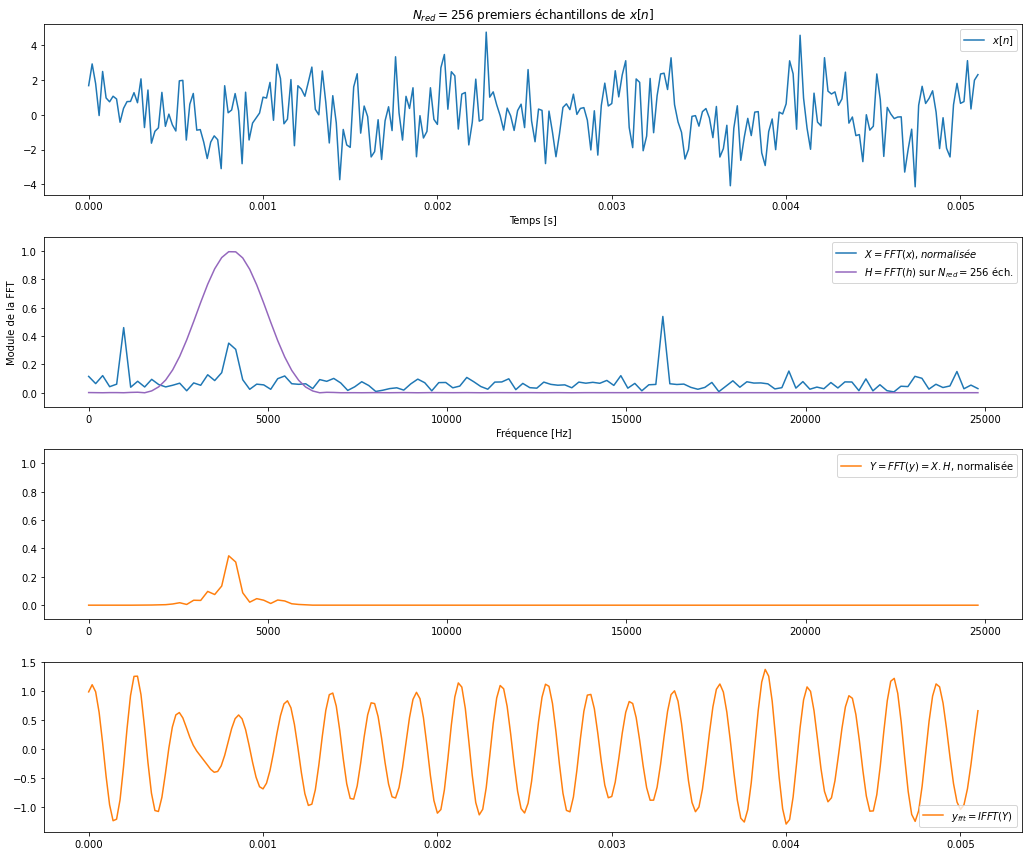

In [5]:
def display_fft_filtering(N_red):
    """ N_red : nombre d'éch de x à filtrer
        y_ref : sortie y obtenue par convolution """
    x_red = x[0:N_red]
    t_red = t[0:N_red]
    fig, axes = plt.subplots(4, 1, figsize=(figs_scale*9, figs_scale*7.5))
    axes[0].plot(t_red, x_red)
    axes[0].set_title("$N_{red} = $" + "{} premiers échantillons de ".format(N_red) + "$x[n]$")
    axes[0].legend(['$x[n]$'])
    axes[0].set_xlabel('Temps [s]')
    X = np.fft.fft(x_red)  # FFT complexe, on doit garder la phase !
    H = np.fft.fft(h, N_red)  # w/ zero-padding
    axes[1].plot(np.linspace(0.0, 0.5, N_red//2, endpoint=False) * Fs, np.abs(X)[0:N_red//2] / N_red, 'C0-')
    axes[1].plot(np.linspace(0.0, 0.5, N_red//2, endpoint=False) * Fs, np.abs(H)[0:N_red//2], 'C4-')
    axes[1].legend(['$X = FFT(x), normalisée$', '$H = FFT(h)$ sur $N_{red}=$' + '{} éch.'.format(N_red)])
    axes[1].set_xlabel('Fréquence [Hz]')
    axes[1].set_ylabel('Module de la FFT')
    axes[1].set_ylim([-0.1, 1.1])
    axes[2].set_ylim([-0.1, 1.1])
    Y = X*H
    axes[2].plot(np.linspace(0.0, 0.5, N_red//2, endpoint=False) * Fs, np.abs(Y)[0:N_red//2] / N_red, 'C1-')
    axes[2].legend(['$Y = FFT(y) = X.H$, normalisée'])
    y_fft = np.real(np.fft.ifft(Y))  # real nécessaire à cause des arrondis sur nbs complexes
    axes[3].plot(t_red, y_fft, 'C1-')
    axes[3].legend(['$y_{fft} = IFFT(Y)$'])
    fig.tight_layout()
    return y_fft

N_blk = 256  # FFT Block size
y_fft = display_fft_filtering(N_blk)

#### Remarques pour les plots ci-dessus
* On affiche les données sous forme de plot classique (en ligne), mais il faut bien garder en tête qu'il s'agit d'échantillons discrets, et non pas de signaux et de TF continus
* La partie de la FFT en fréquences négatives est conservée (et utilisée) mais pas affichée

### Allure des signaux : comparaison avec le filtrage par convolution

On a l'impression que le filtrage fait ressortir notre composante recherchée à 4 kHz. Pour mieux comprendre ce qu'il s'est passé, on va comparer ce signal $y_{fft}$ obtenu via le domaine de Fourier, avec le signal $y_{conv}$ obtenu par convolution, et avec le signal $y_{target}$ qui est *vraiment* contenu dans $x$. On rappelle que c'est ce $y_{target}$ qu'on essaie de retrouver.

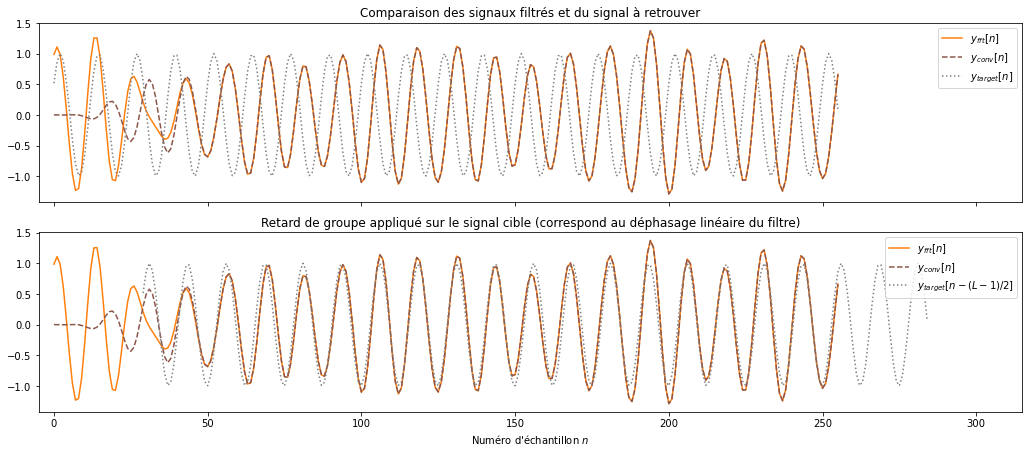

In [6]:
# On re-calcule un y_conv avec une taille adaptée à ce qu'on a fait en FFT
fig, axes = plt.subplots(2, 1, figsize=(figs_scale*9, figs_scale*4), sharex=True)
for i in range(2):
    axes[i].plot(np.arange(0, N_blk), y_fft[0:N_blk], 'C1-')
    axes[i].plot(np.arange(0, N_blk), y_conv[0:N_blk], 'C5--')
axes[0].plot(np.arange(0, N_blk), y_target[0:N_blk], 'C7:')
axes[0].legend(['$y_{fft}[n]$', '$y_{conv}[n]$', '$y_{target}[n]$'])
axes[0].set_title("Comparaison des signaux filtrés et du signal à retrouver")
axes[1].plot((L-1)//2 + np.arange(0, N_blk), y_target[0:N_blk], 'C7:')
axes[1].legend(['$y_{fft}[n]$', '$y_{conv}[n]$', '$y_{target}[n-(L-1)/2]$'])
axes[1].set_xlabel("Numéro d'échantillon $n$")
axes[1].set_title("Retard de groupe appliqué sur le signal cible (correspond au déphasage linéaire du filtre)")
axes[1].set_xlim([-5, N_blk+L])
fig.tight_layout()

#### Qualité du filtrage

Le filtrage pourrait clairement être amélioré, on a des imprécisions dûes au (fort) bruit résiduel non-filtré dans la bande passante. On a par exemple un phénomène d'enveloppe assez remarquable, et une légère différence entre les $4 kHz$ recherchés et l'harmonique fondamentale du résultat du filtrage (pour les deux filtrages, par convolution et "en FFT").

#### Retard de groupe

On voit que les 2 signaux filtrés ont un déphasage par rapport au signal $y_{target}$. Il s'agit du retard de groupe, dont on a parlé en cours, qui existe pour tout filtre à phase linéaire. Le retard vaut ici $\frac{L-1}{2}$ échantillons pour notre filtre de Type I, mais on n'en parlera pas plus dans ce notebook.

#### Continuité en zéro du signal filtré

On remarque un phénomène très intéressant au début du signal : alors que $y_{conv}$ part doucement de la valeur zéro, $y_{fft}$ prend immédiatement des valeurs non-nulles.

Pour $y_{conv}$, le départ de zéro vient du fait qu'on a complété le signal $x[n]$ avec des zéros pour les $n<0$. Comme la convolution est en fait une moyenne pondérée glissante (MA, *Moving Average*), on a pour les premiers $n$ des sorties $y_{conv}[n] \approx 0$. Pour le filtrage dans le domaine de Fourier, on n'a jamais fait ce *zero-padding*. Le signal $y_{fft}$ obtenu par IFFT n'a donc aucune raison de commencer à la valeur zéro.


## Estimation de complexité par filtrage en FFT

On va discuter maintenant de la quantité de calcul nécessaire pour appliquer notre filtre via la FFT. On rappelle que les 3 étapes pour filtrer "en FFT" étaient : FFT, multiplication terme à terme sur $N$ termes, IFFT.

Pour comparer la quantité de calcul avec celle de la méthode par convolution, il faudrait savoir combien d'instructions CPU sont nécessaires pour une FFT (ou une IFFT, quie demande un nombre d'opérations similaire). Malheureusement, cela dépend fortement de l'architecture et de l'implémentation - par exemple : CMSIS-DSP pour ARM Cortex, IntelMKL, OpenBLAS ou FFTW pour x86-64, ... De plus, il n'y a pas seulement *une* FFT, mais *plusieurs* algorithmes de FFT.

On peut quand même donner un ordre de grandeur du nombre d'opérations à effectuer pour *une seule* FFT ou IFFT sur $N = 2^a$ points :

$$
\mathcal{C}_{fft, seule} = \mathcal{O}( {N \log N} )
$$

Pour la FFT de $x$ et $h$ sur $N$ points, et la multiplication terme à terme sur $N$ points également, puis une IFFT, on obtient alors la complexité du filtrage "en FFT" :
$$
\mathcal{C}_{fft} = \mathcal{O} {(3(N \log N) + N)} = \mathcal{O} {(N(3\log N + 1))}
$$

Cette complexité ne donne donne qu'un ordre de grandeur approximatif, mais on constate qu'elle **ne dépend plus de l'ordre du filtre !** On va en discuter dans la suite de ce document.

## Comparaison : filtrage en FFT vs. filtrage par convolution directe

### Coût de calcul

On obtient ici un résultat très intéressant, en comparant $\mathcal{C}_{fft}$ et la complexité $\mathcal{C}_{conv} = \mathcal{O} (NL)$. Le filtrage par FFT est potentiellement moins coûteux si on a :

$$
3 \log N + 1 < L
$$

Même pour un (très) grand signal $x$, $\log N$ restera toujours une valeur relativement faible. Donc, on peut retenir que **pour un filtre RIF d'ordre $L-1$ élevé, le filtrage en FFT peut réduire la quantité de calcul, même pour de très longs signaux à filtrer.** De plus, on va décrire les méthodes Overlap-Add et Overlap-Save, qui permettent de découper le signal en blocs de petite taille $N$. Le gain en utilisant le filtrage par FFT sont alors quasi-certains.

Attention cependant : l'inégalité et le résultat ci-dessus ne sont que des indications. En pratique, il faut vérifier par des tests que la convolution n'est pas la meilleure méthode. Les résultats dépendent fortement de $L$, $N$, et également du compilateur C, de l'architecture et des bibliothèques de FFT utilisés.

### Inconvénients du filtrage par FFT

#### Consommation de mémoire

Lorsque l'on filtre par convolution, on n'a besoin de stocker que les $L$ derniers échantillons de $x$ et de $h$. En comptant également le stockage pour $y$, la quantité totale d'échantillons à stocker est faible :

$$
N_{RAM,conv} = 2L + 1
$$

Avec la FFT, à nouveau, le résultat dépend de l'implémentation. Cependant, on est sûr qu'il faut au minimum garder en mémoire $N>L$ échantillons pour $x$, $N$ pour $h$ avec zero-padding, $N$ échantillons également pour chacune des FFTs, et $N$ pour $y$ en sortie. En plus, il faudrait comptabiliser les variables nécessaires pour l'algorithme de FFT. On a donc une consommation de mémoire pour le filtrage par FFT de :

$$
N_{RAM,fft} > 5N > 2.5 N_{RAM,conv}
$$

Sur un microcontrôleur, cela peut vraiment poser problème. Pour du post-traitement de signaux sur ordinateur, il n'y a *a priori* pas de problème de RAM, et pourra sans risque se tourner vers les méthodes présentées ici.

#### Latence

L'autre problème avec le filtrage par FFT, c'est que l'on doit attendre d'avoir reçu $N$ échantillons du signal $x$ avant de faire le filtrage et d'envoyer les échantillons $y[n]$ en sortie. On parle de tampon, de segment, ou plus souvent de *buffer*. Typiquement, en traitement audio/vidéo sur ordinateur, tout fonctionne avec des buffers en entrée et en sortie. On notera $N_{blk}$ la taille d'un buffer.

Dans un contexte de filtrage temps-réel (c'est-à-dire : pas dans le cas d'un post-traitement après acquisition) sur microcontrôleur, le retard d'un échantillon $y[n]$ en sortie est donc de $N T_s$. Si on souhaite quand même filtrer en FFT sur un microcontrôleur, il est possible de faire des acquisitions de $x$ par petits buffers, afin de réduire le retard en sortie. On peut alors faire du filtrage en FFT en réduisant la taille $N_{blk}$ du buffer.

On va d'ailleurs expliquer que filtrer en FFT "par blocs" permet de réduire la latence d'un filtre temps-réel, mais aussi de réduire le coût total du calcul dans le cas d'un post-traitement.



---

# Filtrage par blocs dans le domaine de Fourier

## Séparation en blocs de taille $N_{blk}$

Comme expliqué précédemment, on va décomposer le signal $x[n]$ en $Q$ segments de taille $N_{blk} = 2^b$, qui serviront à filtrer dans le domaine fréquentiel. Pour $0 \leq q < Q$, on notera $x_q[n]$ le segment de $x[n]$ tel que :

$$
x_q[n] = x[n] \text{  si  } q N_{blk} \leq n < (q+1) N_{blk} 
$$
$$
x_q[n] = 0 \text{  sinon}
$$

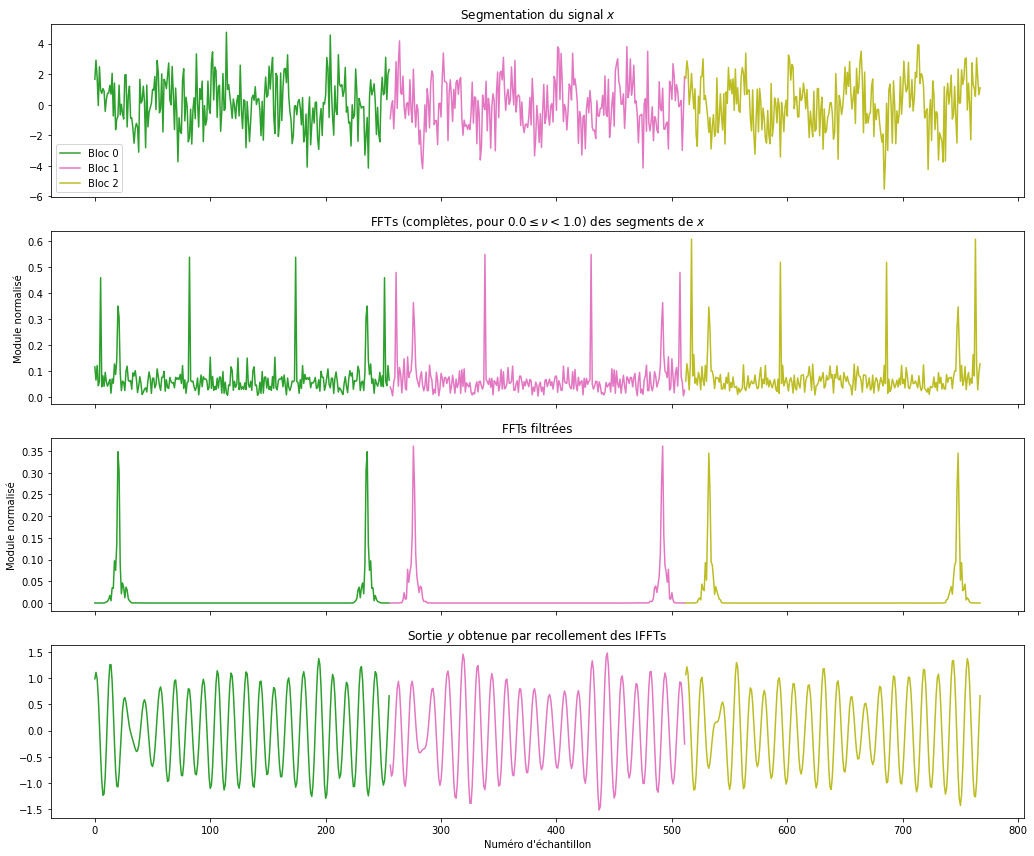

In [7]:
# On garde le N_blk précédent, pour comparer/retrouver les résultats
Q = 3
def get_x_q(x, q, N_blk, n_offset=0):
    " Retourne un tuple (t, x_q) avec les abscisses (numéros d'échantillons) et le segment x_q de x "
    return np.arange(q * N_blk, (q+1) * N_blk) - n_offset, x[q * N_blk - n_offset : (q+1) * N_blk - n_offset]
fig, axes = plt.subplots(4, 1, figsize=(figs_scale*9, figs_scale*7.5), sharex=True)
H_q = np.fft.fft(h, N_blk)  # h zero-padded
y_fft = list()
for q in range(Q):
    linefmt = ['C2-', 'C6-', 'C8-', 'C3-'][q]
    abscisses_echantillons, x_q = get_x_q(x, q, N_blk)
    axes[0].plot(abscisses_echantillons, x_q, linefmt)
    X_q = np.fft.fft(x_q)
    axes[1].plot(abscisses_echantillons, np.abs(X_q) / N_blk, linefmt)
    Y_q = X_q * H_q
    axes[2].plot(abscisses_echantillons, np.abs(Y_q) / N_blk, linefmt)
    y_q = np.real(np.fft.ifft(Y_q))
    y_fft += y_q.tolist()
    axes[3].plot(abscisses_echantillons, y_q, linefmt)
y_fft = np.asarray(y_fft)
axes[0].set_title("Segmentation du signal $x$")
axes[0].legend(['Bloc {}'.format(q) for q in range(Q)])
axes[1].set_title(r"FFTs (complètes, pour $0.0 \leq \nu < 1.0$) des segments de $x$")
axes[1].set_ylabel("Module normalisé")
axes[2].set_title("FFTs filtrées")
axes[2].set_ylabel("Module normalisé")
axes[3].set_xlabel("Numéro d'échantillon")
axes[3].set_title("Sortie $y$ obtenue par recollement des IFFTs")
fig.tight_layout()

On constate que cette méthode pose un gros problème : le signal obtenu par recollement n'est pas continu ! Le signal $x$ peut présenter des discontinuités (bien visibles au niveau des limites de certains segments), car il est composé d'un bruit gaussien. Le signal $y$ filtré, lui, n'est plus censé contenir de hautes fréquences, et donc pas de discontinuités.

La figure ci-dessous permet de mieux les visualiser.

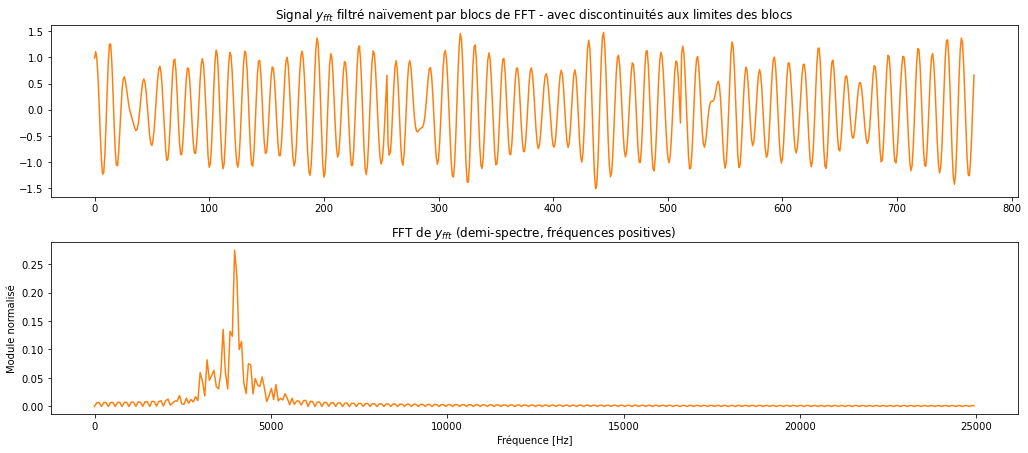

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(figs_scale*9, figs_scale*4))
axes[0].plot(np.arange(0,Q*N_blk), y_fft, 'C1-')
axes[0].set_title("Signal $y_{fft}$ filtré naïvement par blocs de FFT - avec discontinuités aux limites des blocs")
axes[1].set_xlabel("Numéro d'échantillon $n$")
axes[1].plot(np.arange(0, N_blk*Q//2)*Fs/(Q*N_blk), np.abs(np.fft.fft(y_fft))[0: N_blk*Q//2] / (N_blk*Q), 'C1-')
axes[1].set_ylabel("Module normalisé")
axes[1].set_title("FFT de $y_{fft}$ (demi-spectre, fréquences positives)")
axes[1].set_xlabel('Fréquence [Hz]')
fig.tight_layout()

On constate plus facilement les discontinuités (par exemple entre les échantillons $n=255$ et $n=256$), et que le spectre du signal recollé n'est pas la moyenne des spectres de chaque segment.
On observe quelque chose qui ressemble à un phénomène d'*aliasing* (de repliement spectral) similaire à celui que vous devez observer et expliquer très précisément dans la séance 2 de pratique Matlab. Ce n'est toutefois pas exactement le même phénomène.

Pour que ce notebook reste proche de la pratique (et de l'implémentation d'un filtre), on ne va pas chercher à expliquer mathématiquement ce phénomène. On va par contre évidemment donner des solutions.

## Méthode Overlap-Save

### Taille du recouvrement (*overlap*)

De manière intuitive, pour supprimer les discontinuités, on peut en quelque sorte "mélanger" les signaux de blocs consécutifs $x_q[n]$ et $x_{q+1}[n]$, pour les échantillons proches de la limite entre les deux blocs. On ne va pas rigoureusement démontrer pourquoi est-ce que cela fonctionne. Cependant, on sait qu'un filtre RIF de taille $L$ s'applique par convolution sur $L$ échantillons d'entrée. Pour une sortie $y[n]$ donnée, le filtre RIF n'agit que sur $L$ échantillons simultanément. Donc, si on fait le "mélange" des blocs $x_q[n]$ et $x_{q+1}[n]$ sur un nombre $L$ d'échantillons (en pratique, $L-1$ échantillons seront suffisants) on peut espérer supprimer la discontinuité.

### Filtrage dans le domaine fréquentiel par Overlap-Save

Avec la méthode Overlap-Save, on va créer des blocs $x_q$ qui se superposent à gauche et à droite avec les blocs $x_{q-1}$ et $x_{q+1}$. Chaque zone de recouvrement entre un bloc $x_{q}$ et un bloc $x_{q+1}$. Chaque recouvrement est de largeur $L-1$. 

Pour ne pas créer de discontinuité entre des blocs de sortie $y_{q}$ et $y_{q+1}$, l'idée générale est la suivante :
* La fin du bloc $x_{q}$ contient les $L-1$ échantillons du début de $x_{q+1}$
    * La fin du bloc $y_{q}$ se comportera donc comme le début du de $y_{q+1}$, car le filtrage appliqué est toujours le même
    * De plus : le début de $x_{q+1}$ contient la fin de $x_{q}$. On a un "double recouvrement", voir figures ci-dessous
* Chaque bloc $x_q$ a $L-1$ échantillons superflus à gauche, car ces échantillons appartiennent réellement au bloc $x_{q-1}$, et également $L-1$ échantillons superflus à droite. On garde ces $2(L-1)$ échantillons pour le filtrage, mais on les supprime avant recollement

C'est une explication intuitive - on ne démontrera pas dans ce notebook pourquoi cela fonctionne. Pour le tout premier recouvrement (à gauche du bloc $x_0$), on fait faire un classique bourrage de zéros. Pour les autres détails d'implémentation : voir code Python ci-dessous (la syntaxe est très proche de Matlab, mais n'oubliez pas que les tableaux Python/NumPy commencent par l'index 0).

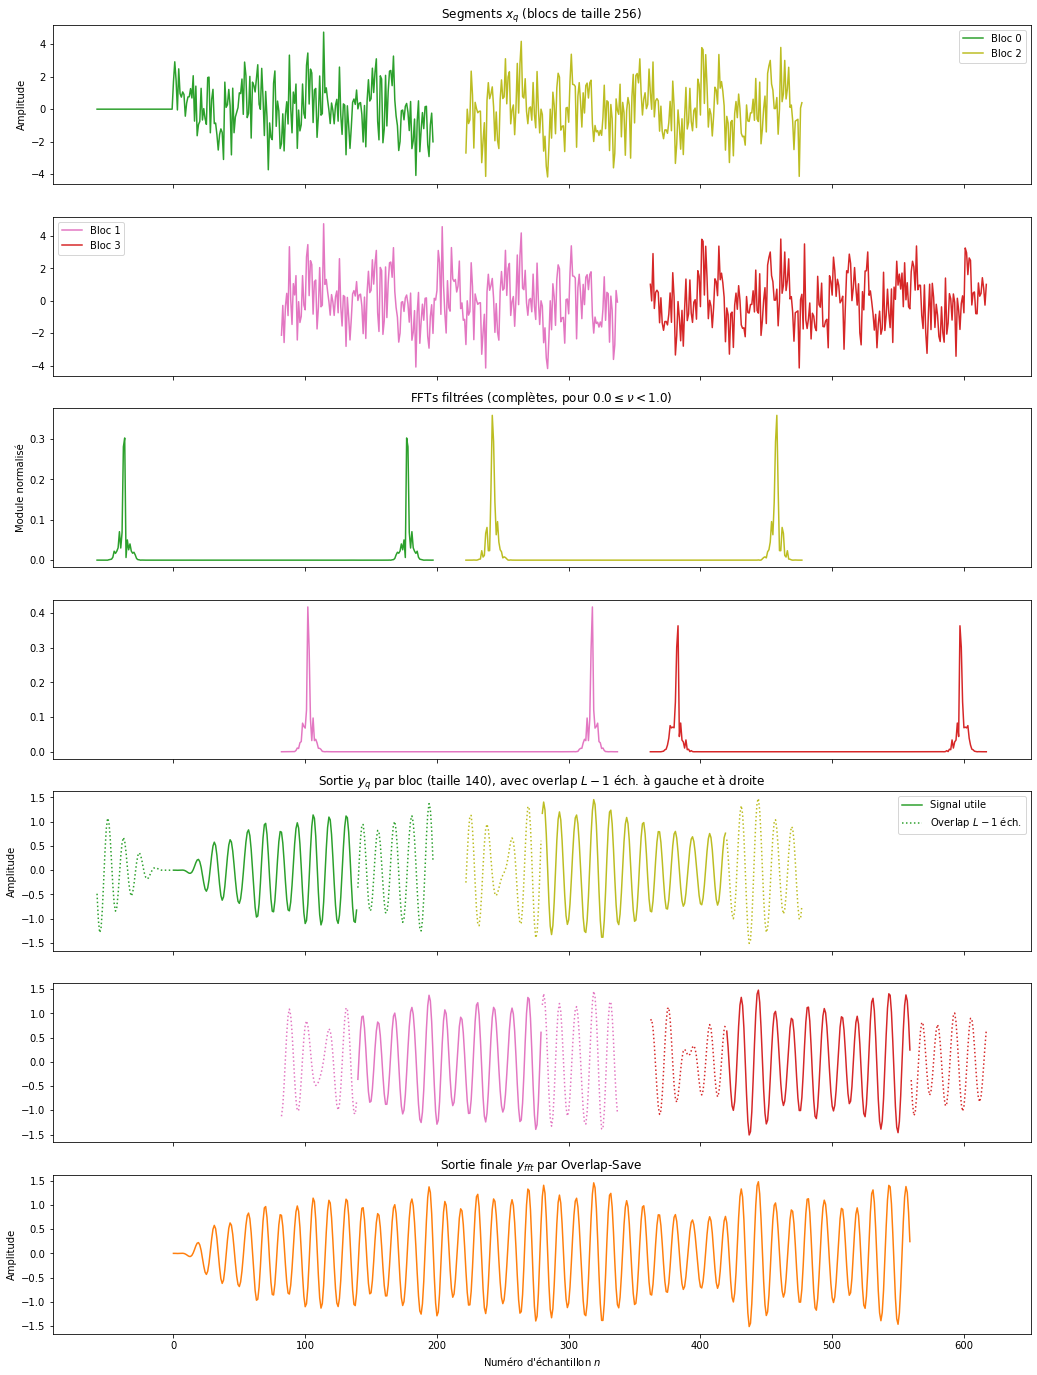

In [9]:
Q = 4 # On affiche 4 blocs pour mieux comprendre l'overlap
fig, axes = plt.subplots(7, 1, figsize=(figs_scale*9, figs_scale*12), sharex=True)
H_q = np.fft.fft(h, N_blk)  # h zero-padded
y_fft = list()
for q in range(Q):
    linefmt = ['C2-', 'C6-', 'C8-', 'C3-'][q]
    linefmt_overlap = ['C2:', 'C6:', 'C8:', 'C3:'][q]
    if q==0:
        x_q = np.hstack((np.zeros(L-1), x[0 : N_blk-(L-1)]))
        abscisses_echantillons = np.arange(-(L-1), N_blk-(L-1)) 
    else:
        start_idx = -(L-1) + q * (N_blk - 2*(L-1))
        x_q = x[start_idx: start_idx + N_blk]
        abscisses_echantillons = np.arange(start_idx, start_idx + N_blk)
    axes[q%2].plot(abscisses_echantillons, x_q, linefmt)
    X_q = np.fft.fft(x_q)
    Y_q = X_q * H_q
    axes[2 + q%2].plot(abscisses_echantillons, np.abs(Y_q) / N_blk, linefmt)
    y_q = np.real(np.fft.ifft(Y_q))
    y_saved = y_q[L-1:N_blk-(L-1)]
    y_fft += y_saved.tolist()  # ICI on fait le suppression des échantillons de transition
    axes[4 + q%2].plot(abscisses_echantillons[L-1:N_blk-(L-1)], y_saved, linefmt)
    axes[4 + q%2].plot(abscisses_echantillons[0:L-1], y_q[0:L-1], linefmt_overlap)
    axes[4 + q%2].plot(abscisses_echantillons[N_blk-(L-1):], y_q[N_blk-(L-1):], linefmt_overlap)
y_fft = np.asarray(y_fft)
axes[0].set_title("Segments $x_q$ (blocs de taille {})".format(N_blk))
axes[0].set_ylabel("Amplitude")
axes[0].legend(['Bloc {}'.format(q) for q in range(0, Q, 2)])
axes[1].legend(['Bloc {}'.format(q) for q in range(1, Q, 2)])
axes[2].set_title(r"FFTs filtrées (complètes, pour $0.0 \leq \nu < 1.0$)")
axes[2].set_ylabel("Module normalisé")
axes[4].set_title("Sortie $y_q$ par bloc (taille {}), avec overlap $L-1$ éch. à gauche et à droite".format(N_blk - 2 * (L-1)))
axes[4].set_ylabel("Amplitude")
axes[4].legend(['Signal utile', 'Overlap $L-1$ éch.'])
axes[6].plot(np.arange(0, y_fft.shape[0]), y_fft, 'C1-')
axes[6].set_title("Sortie finale $y_{fft}$ par Overlap-Save")
axes[6].set_ylabel("Amplitude")
axes[6].set_xlabel("Numéro d'échantillon $n$")
fig.tight_layout()

On observe beaucoup de phénomènes intéressants sur cette figure, mais on ne va pas tous les décrire et expliquer ici. Les plus importants sont :
* La sortie $y_{fft}$ est bien continue, on va ci-dessous regarder son spectre et la comparer à $y_{conv}$ obtenue par convolution
* Dès qu'on a calculé un bloc $y_q$, on peut commencer à envoyer les sorties $y[n]$ correspondantes (dans un cadre temps-réel), avec une latence qui dépend (entre autres) de la taille des blocs $x_q$

Le nom *save* de cette méthode peut sembler étrange, car elle fait plutôt *discard*, une suppression des échantillons en recouvrement après filtrage (les échantillons en pointillés sur la figure). Elle peut être retrouvée sous le nom *overlap-discard* dans la littérature.

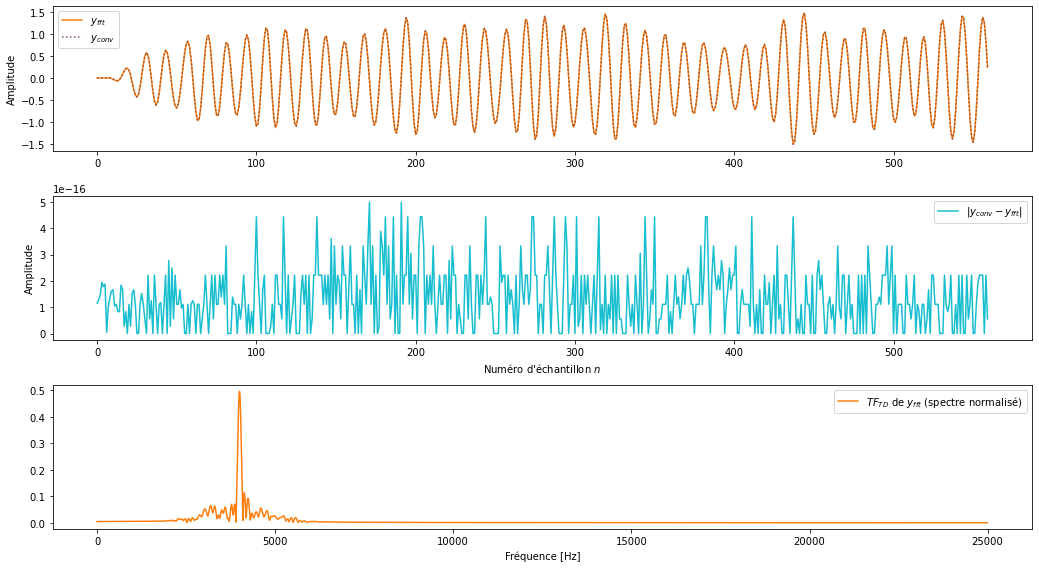

In [10]:
# Comparaison des signaux filtrés
fig, axes = plt.subplots(3, 1, figsize=(figs_scale*9, figs_scale*5))
axes[0].plot(np.arange(0, y_fft.shape[0]), y_fft, 'C1-')
axes[0].plot(np.arange(0, y_fft.shape[0]), y_conv[0:y_fft.shape[0]], 'C5:')
axes[0].legend(["$y_{fft}$", "$y_{conv}$"])
axes[0].set_ylabel('Amplitude')
axes[1].plot(np.arange(0, y_fft.shape[0]), np.abs(y_conv[0:y_fft.shape[0]] - y_fft), 'C9-')
axes[1].legend(["$| y_{conv} - y_{fft} | $"])
axes[1].set_ylabel('Amplitude')
axes[1].set_xlabel("Numéro d'échantillon $n$")
axes[2].plot(np.arange(0, M//2) * Fs / M, np.abs(np.fft.fft(y_fft, M)[0:M//2]) / y_fft.shape[0], 'C1-')
axes[2].legend(["$TF_{TD}$ de $y_{fft}$ (spectre normalisé)"])
axes[2].set_xlabel("Fréquence [Hz]")
fig.tight_layout()

On constate que la différence entre $y_{conv}$ et $y_{fft}$ est un bruit numérique très faible, d'ordre $10^{-16}$. Cette différence est dûe à la manière de calculer le filtrage et à la représentation des nombres à virgule flottante, qui n'ont pas une précision infinie. Les signaux $y_{conv}$ et $y_{fft}$ sont bien les mêmes : la méthode Overlap-Save permet donc d'appliquer un filtre directement dans le domaine de Fourier, en économisant en général du temps de calcul (car on évite la convolution) au prix d'une latence plus élevée.

On constate également que le spectre correspond maintenant bien au résultat attendu (voir TFTD du filtre en début de notebook).

## Méthode Overlap-Add

Une deuxième méthode existe pour faire un filtrage dans le domaine fréquentiel. L'objectif est toujours ici d'éviter de filtrer par convolution, à cause du coût de calcul énorme, tout en gardant un filtrage "temps-réel" si possible.

Cette méthode, plutôt que de supprimer des échantillons en recouvrement, va les additionner. Le recouvrement est ici différent : les échantillons en *overlap* seront en fait uniquement des zéros (zero-padding de taille $L-1$ à gauche et à droite de chaque bloc $x_q$). Cette méthode est peut-être plus intuitive que la précédente : puisque le filtrage est linéaire, on peut l'appliquer à des portions de signal, et le bourrage de $L-1$ zéros permet d'assurer la continuité du signal (on ne va pas le démontrer ici).

Les détails sont disponibles dans l'implémentation ci-dessous, mais la figure devrait permettre de comprendre comment la méthode fonctionne.

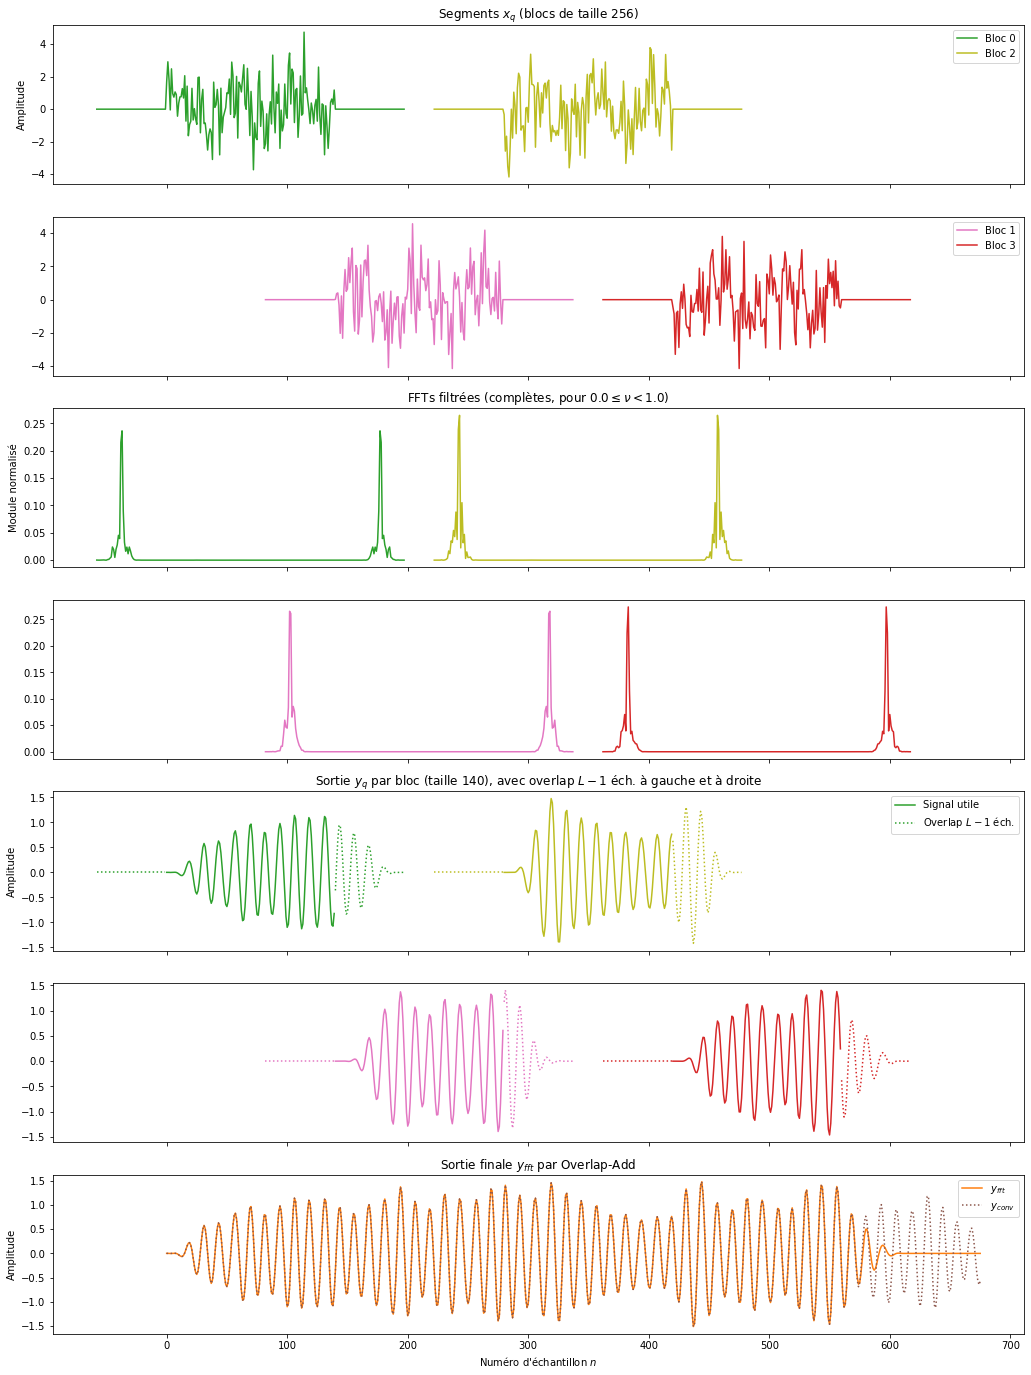

In [11]:
fig, axes = plt.subplots(7, 1, figsize=(figs_scale*9, figs_scale*12), sharex=True)
N_sub_block = (N_blk - 2*(L-1))
y_fft = np.zeros(Q * N_sub_block + 2*(L-1))
for q in range(Q):
    linefmt = ['C2-', 'C6-', 'C8-', 'C3-'][q]
    linefmt_overlap = ['C2:', 'C6:', 'C8:', 'C3:'][q]
    idx_offset = q * N_sub_block
    x_q = np.hstack((np.zeros(L-1), x[0+idx_offset : N_blk-2*(L-1)+idx_offset], np.zeros(L-1)))
    start_idx = -(L-1) + idx_offset
    abscisses_echantillons = np.arange(start_idx, start_idx + N_blk)
    axes[q%2].plot(abscisses_echantillons, x_q, linefmt)
    X_q = np.fft.fft(x_q)
    Y_q = X_q * H_q
    axes[2 + q%2].plot(abscisses_echantillons, np.abs(Y_q) / N_blk, linefmt)
    y_q = np.real(np.fft.ifft(Y_q))
    y_fft[q*N_sub_block : (q+1)*N_sub_block + (L-1)] += y_q[L-1:]  # addition sur les zones de recouvrement
    axes[4 + q%2].plot(abscisses_echantillons[L-1:N_blk-(L-1)], y_q[L-1:N_blk-(L-1)], linefmt)  # zone centrale sans overlap
    axes[4 + q%2].plot(abscisses_echantillons[0:L-1], y_q[0:L-1], linefmt_overlap)
    axes[4 + q%2].plot(abscisses_echantillons[N_blk-(L-1):], y_q[N_blk-(L-1):], linefmt_overlap)
axes[0].set_title("Segments $x_q$ (blocs de taille {})".format(N_blk))
axes[0].set_ylabel("Amplitude")
axes[0].legend(['Bloc {}'.format(q) for q in range(0, Q, 2)])
axes[1].legend(['Bloc {}'.format(q) for q in range(1, Q, 2)])
axes[2].set_title(r"FFTs filtrées (complètes, pour $0.0 \leq \nu < 1.0$)")
axes[2].set_ylabel("Module normalisé")
axes[4].set_title("Sortie $y_q$ par bloc (taille {}), avec overlap $L-1$ éch. à gauche et à droite".format(N_blk - 2 * (L-1)))
axes[4].set_ylabel("Amplitude")
axes[4].legend(['Signal utile', 'Overlap $L-1$ éch.'])
axes[6].plot(np.arange(0, y_fft.shape[0]), y_fft, 'C1-')
axes[6].plot(np.arange(0, y_fft.shape[0]), y_conv[0:y_fft.shape[0]], 'C5:')
axes[6].set_title("Sortie finale $y_{fft}$ par Overlap-Add")
axes[6].legend(["$y_{fft}$", "$y_{conv}$"])
axes[6].set_ylabel("Amplitude")
axes[6].set_xlabel("Numéro d'échantillon $n$")
fig.tight_layout()

On remarque que :
* Chaque bloc filtré ne comporte que des échantillons nuls dans le recouvrement de gauche, et des échantillons non-nuls dans le recouvrement de droite. Ceci vient du fait que le filtre est causal - cette propriété est bien évidemment conservée lorsque l'on passe dans le domaine de Fourier, puis qu'on fait une IFFT
* Le signal filtré est le même que celui obtenu par convolution directe

## Comparaison des méthodes Overlap-Save et Overlap-Add

* La méthode Overlap-Add fait L-1 additions supplémentaires par bloc, par rapport à la méthode Overlap-Save
* Pour calculer le filtrage du bloc $x_q$, Overlap-Add n'a pas besoin d'attendre encore les $L-1$ premiers échantillons du bloc $x_{q+1}$
    * La latence peut donc être réduite de $L-1$ échantillons par rapport à Overlap-Save
    * Attention cependant : avec Overlap-Add, tant qu'on a pas le bloc $x_{q+1}$, on ne peut pas envoyer en sortie les $L-1$ derniers échantillons du bloc $y_q$

---

# Le filtrage numérique parfait est-il possible ? (spoiler alert : non)

À ce stade, on peut se poser la question suivante : puisqu'on a des méthodes efficaces pour faire du filtrage directement sur la FFT... ne pourrait-on pas alors faire un filtrage idéal, dans le domaine fréquentiel ? Pourquoi s'embêter à synthétiser un filtre $h[n]$ à $L$ coefficients, pour ensuite calculer sa FFT $H[k]$ ?

On pourrait se dire "je vais directement imposer les valeurs de la FFT $H[k]$, comme ça la réponse fréquentielle de mon filtre sera exactement celle que je veux". On pourrait choisir un gabarit idéal (en rouge pointillé le schéma ci-dessous) et faire du filtrage "chirurgical" sans effort, plutôt que de faire des compromis avec réponse fréquentielle comprenant des oscillations (courbe rouge ci-dessous).

![](http://herve.boeglen.free.fr/Tsignal/chapitre3/typefiltre.gif)

Cela va poser évidemment un problème (sinon, ça serait trop facile). Il est important de se souvenir que la FFT (qui est un algorithme de TFD) n'est qu'un **échantillonnage de la TFTD** - dans ce cours de TNS, beaucoup de phénomènes viennent de là. Or, la TFTD est la *vraie* réponse fréquentielle du filtre, et c'est elle qui va nous indiquer comment réagira notre filtre sur des signaux.

Il y a un autre problème : une FFT ne contient qu'un nombre fini de points. Par exemple, on n'est pas sûr que la fréquence $4kHz$ tombe "tout pile" sur un des points de la FFT - d'ailleurs on peut faire le calcul : ça ne sera jamais le cas à $F_s = 50kHz$ et des FFT par blocs de longueur $2^a$. Si on définit un filtre uniquement par sa FFT, on n'aura donc pas la possibilité de mettre un gabarit passe-bande pour $4kHz$ précisément.

On va tout de même essayer de "synthétiser" un filtre directement dans le domaine de Fourier, en imposant les valeurs de $H[k]$, et voir la réponse impulsionnelle $h[n]$ correspondante. L'objectif de la figure ci-dessous est d'expliquer pourquoi cette méthode naïve ne fonctionne pas. La visualisation de la TFTD devrait vous permettre de comprendre sans plus d'explications.

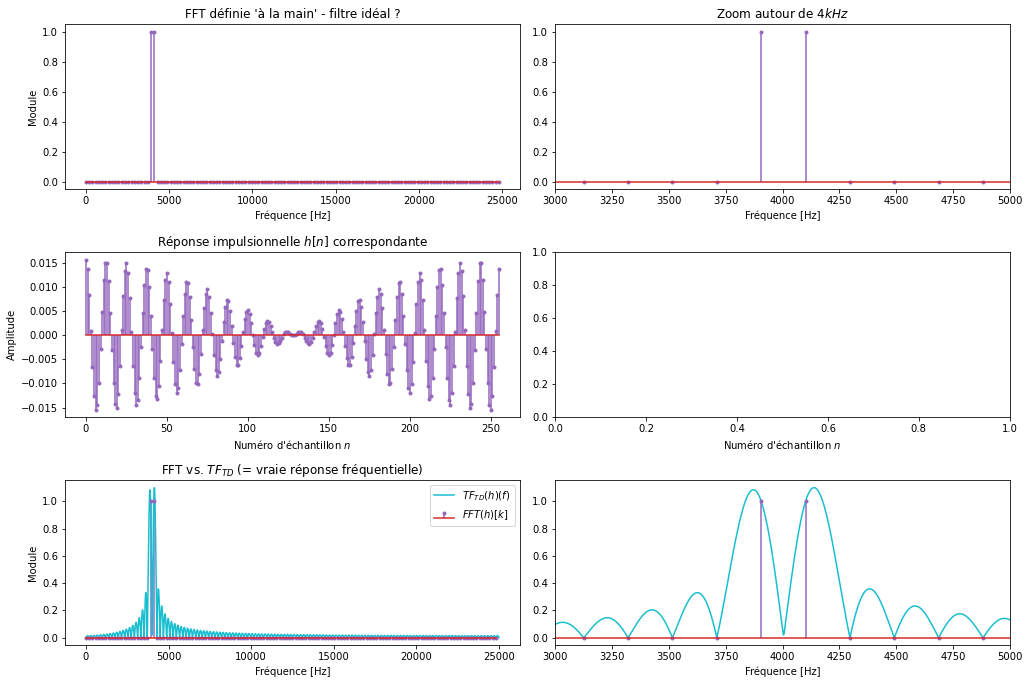

In [12]:
H_defini_en_TFD = np.zeros(N_blk, dtype=complex)
phi = np.pi * 0.0
for k in [20, 21]:
    H_defini_en_TFD[k] = 1.0 * np.exp(1j * phi)
    H_defini_en_TFD[N_blk-k] = 1.0 * np.exp(-1j * phi)
h_defini_en_TFD = np.fft.ifft(H_defini_en_TFD)
fig, axes = plt.subplots(3, 2, figsize=(figs_scale*9, figs_scale*6))
for i in range(2):
    axes[0][i].stem(np.arange(0, N_blk//2) * Fs / N_blk, np.abs(H_defini_en_TFD[0:N_blk//2]), linefmt='C4-', markerfmt='C4.')
    axes[0][i].set_xlabel('Fréquence [Hz]')
    axes[2][i].set_xlabel('Fréquence [Hz]')
    # résolution via zero-padding tellement énorme que visuellement, on aura la TFTD
    # (pas assez de pixels à l'écran pour faire la différence)
    axes[2][i].plot(np.arange(0, M//2) * Fs / M, np.abs(np.fft.fft(h_defini_en_TFD, M)[0:M//2]), 'C9-')
    axes[2][i].stem(np.arange(0, N_blk//2) * Fs / N_blk, np.abs(np.fft.fft(h_defini_en_TFD)[0:N_blk//2]), linefmt='C4-', markerfmt='C4.')
    axes[1][i].set_xlabel("Numéro d'échantillon $n$")
axes[0][1].set_xlim([3000, 5000])
axes[2][1].set_xlim([3000, 5000])
axes[0][0].set_ylabel("Module")
axes[1][0].stem(np.arange(0, N_blk), np.real(h_defini_en_TFD), linefmt='C4-', markerfmt='C4.')
axes[1][0].set_ylabel("Amplitude")
axes[2][0].set_ylabel("Module")
axes[0][0].set_title("FFT définie 'à la main' - filtre idéal ?")
axes[0][1].set_title("Zoom autour de $4kHz$")
axes[1][0].set_title("Réponse impulsionnelle $h[n]$ correspondante")
axes[2][0].set_title("FFT vs. $TF_{TD}$ (= vraie réponse fréquentielle)")
axes[2][0].legend(["$TF_{TD}(h)(f)$", "$FFT(h)[k]$"])
fig.tight_layout()


On constate que le filtre obtenu pour une TFD définie à la main est un très mauvais filtre. Il a énormément d'oscillations, et surtout se comporte comme un réjecteur à $4kHz$. On n'a donc absolument pas le comportement fréquentiel espéré.

Enfin, on peut réfléchir par rapport à l'ordre du filtre. Un filtre défini par un TFD de $Q$ points aura un ordre $L=Q$. Or, pour faire un filtre aux transitions infiniment raides, il faudrait un ordre infini (phénomène de Gibbs). Un tel filtre serait de toute façon impossible à appliquer en pratique (cf. retard de groupe, et effets de bords pour le filtrage naïf par blocs de FFT).

# Pour aller plus loin - filtrage via FFT

#### Convolution cyclique

Le problème des discontinuités au recollement peut être expliqué en introduisant l'opération de *convolution cyclique*, dont on n'a pas parlé dans ce cours.

#### Choix des paramètres $N_{blk}$ et $L$

Le paramètre $L$ dépend de l'ordre du filtre dont vous avez besoin - c'est de la synthèse de filtre, et c'est ce sur quoi vous travaillez principalement dans la séance 3 de pratique Matlab.

Le filtrage par convolution reste le choix par défaut pour un filtrage temps-réel, par ex. sur un microcontrôleur. Pour savoir si un filtrage via FFT peut être intéressant, il y a beaucoup de critères à prendre en compte, et il faut faire des tests en implémentant réellement vos filtres. On a évoqué certains de ces critères dans ce notebook, mais vous trouverez plus d'informations et de guides techniques en ligne (ex : quel est le $N_{blk}$ optimal ?).